# CSO `observations` API Demonstration

2020-12-1. https://github.com/emiliom

Demonstration of the use of the CSO `observations` API. For more documentation see https://github.com/communitysnowobs/cso-api/blob/master/README.md

In [1]:
import json

import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

## Issue request and load results into a GeoDataFrame

Bounding box request parameters will be taken from `CSO_domains.json`

In [2]:
# Load CSO domain JSON
domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()

# Domain to be used
domain = 'WY'

In [3]:
# Domain bounding box and projection
Bbox = domains[domain]['Bbox']
stn_proj = domains[domain]['stn_proj']

In [4]:
params = {
  "bbox": f"{Bbox['lonmin']}, {Bbox['latmax']}, {Bbox['lonmax']}, {Bbox['latmin']}",
  "startDate": '2020-1-1',
  "endDate": '2020-12-1',
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

In [5]:
CSO_gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)
CSO_gdf.sort_values('timestamp', inplace=True)

## Explore the dataset

In [6]:
len(CSO_gdf)

86

In [7]:
CSO_gdf.head()

,geometry,id,author,depth,source,timestamp,elevation
85,POINT (-110.97310 43.76708),qD5QaAkQ,Katie O’Connell,65.0,MountainHub,2020-01-04T18:18:33.223Z,2296.751953
84,POINT (-110.99522 43.49353),u9hatmMq,Allen OBannon,105.0,MountainHub,2020-01-04T19:21:42.075Z,2450.624756
83,POINT (-110.95716 43.48805),s0MgTjy7,Karsten von Hoesslin,292.1,MountainHub,2020-01-05T00:03:57.537Z,2647.235352
82,POINT (-110.95701 43.48805),i9feyDwZ,Karsten von Hoesslin,292.1,MountainHub,2020-01-05T00:13:33.374Z,2648.658936
81,POINT (-110.76361 43.48320),EQt6nRbd,Karsten von Hoesslin,115.0,MountainHub,2020-01-05T00:15:04.654Z,1897.777832


In [8]:
CSO_gdf.tail()

,geometry,id,author,depth,source,timestamp,elevation
4,POINT (-110.87648 43.58714),FzekSyQ4,Mike Rheam,140.0,SnowPilot,2020-11-28T17:45:00.000Z,2391.984619
3,POINT (-110.85176 43.60265),geUcj+e2,Josh Pope,120.0,SnowPilot,2020-11-29T17:00:00.000Z,2289.968262
2,POINT (-110.96463 43.48619),hLx1UfCo,Chris Ebeling,112.0,SnowPilot,2020-11-29T22:00:00.000Z,2466.420898
1,POINT (-110.87006 43.59078),Qotmr46r,Eric Worth,110.0,SnowPilot,2020-11-30T17:55:00.000Z,2348.075928
0,POINT (-110.86924 43.59091),GMuMlFQF,Josh Pope,130.0,SnowPilot,2020-11-30T18:30:00.000Z,2341.450928


Now for "MountainHub" source only:

In [9]:
CSO_gdf[CSO_gdf.source == 'MountainHub'].tail()

,geometry,id,author,depth,source,timestamp,elevation
25,POINT (-110.89353 43.75956),pxp5gyZL,Katie O’Connell,230.000000,MountainHub,2020-02-23T21:07:29.868Z,2770.230713
24,POINT (-110.59531 43.66950),opQJZM+k,Danny Martin,70.999997,MountainHub,2020-03-05T17:44:05.016Z,2158.296143
16,POINT (-110.15781 43.78368),3T9epvFJ,JD,55.000000,MountainHub,2020-11-21T19:08:00.023Z,2726.643311
9,POINT (-110.12116 43.73950),VOs5fZDA,JD,70.000000,MountainHub,2020-11-25T22:03:23.806Z,2908.590820
7,POINT (-110.23978 43.77594),EiU/rtyx,JD,40.000000,MountainHub,2020-11-26T20:29:12.164Z,2559.177490


In [10]:
CSO_gdf[['source', 'timestamp']].groupby(['source']).agg(['count', 'min', 'max'])

timestamp                                                    
                count                       min                       max
source                                                                   
MountainHub        49  2020-01-04T18:18:33.223Z  2020-11-26T20:29:12.164Z
SnowPilot          37  2020-02-01T19:36:00.000Z  2020-11-30T18:30:00.000Z

## Plot the points

Symbolize by source and plot on top of a terrain basemap.

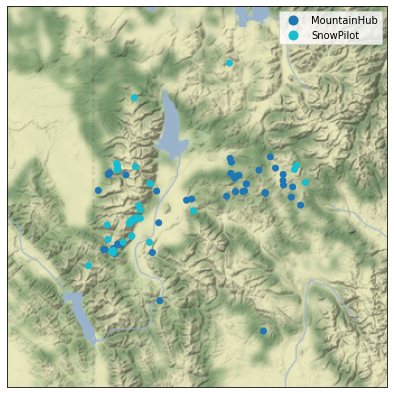

In [11]:
bnd = CSO_gdf.geometry.bounds
stamen_terrain = cimgt.Stamen('terrain-background')
dx, dy = 0.4, 0.2

fig, ax = plt.subplots(
    figsize=(7, 7), subplot_kw={"projection": stamen_terrain.crs}
)
ax.set_extent([bnd.minx.min() - dx, bnd.maxx.max() + dx, bnd.miny.min() - dy, bnd.maxy.max() + dy])

ax.add_image(stamen_terrain, 8)
CSO_gdf.plot(ax=ax, column='source', categorical=True, legend=True, transform=ccrs.PlateCarree());